In [58]:
import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn import metrics, datasets, linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss, roc_auc_score
import matplotlib.pyplot as plt 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error


plt.rc("font", size=14)

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.info()
print(train.shape)
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 66.2+ KB
(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [59]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [60]:
train_data = train.copy()
train_data["Embarked"] = train_data["Embarked"].fillna(train["Embarked"].mode()[0], inplace = False)
train_data["Age"] = train_data["Age"].fillna(train["Age"].mean(), inplace = False)


In [61]:
train_data['Age'] = pd.to_numeric(train_data['Age'])
train_data['Embarked'] = train_data['Embarked'].astype(str)

cat_features = [ 'Sex', 'Embarked']
encoder = LabelEncoder()
train_data[cat_features] = train_data[cat_features].apply(encoder.fit_transform)
train_data.drop(["Name", "Cabin", "Ticket", "PassengerId"], axis = 1, inplace = True)

print(train_data.head())

   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked
0         0       3    1  22.0      1      0   7.2500         2
1         1       1    0  38.0      1      0  71.2833         0
2         1       3    0  26.0      0      0   7.9250         2
3         1       1    0  35.0      1      0  53.1000         2
4         0       3    1  35.0      0      0   8.0500         2


In [62]:
test_data = test.copy()

test_data["Age"] = test_data["Age"].fillna(test["Age"].mean(), inplace = False)
test_data["Fare"] = test_data["Fare"].fillna(test["Fare"].mode()[0], inplace = False)

test_data['Age'] = pd.to_numeric(test_data['Age'])
test_data['Embarked'] = test_data['Embarked'].astype(str)

cat_features = [ 'Sex', 'Embarked']
encoder = LabelEncoder()
test_data[cat_features] = test_data[cat_features].apply(encoder.fit_transform)
test_data.drop(["Name", "Cabin", "Ticket", "PassengerId"], axis = 1, inplace = True)

test_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,34.5,0,0,7.8292,1
1,3,0,47.0,1,0,7.0000,2
2,2,1,62.0,0,0,9.6875,1
3,3,1,27.0,0,0,8.6625,2
4,3,0,22.0,1,1,12.2875,2


Cross-validated scores: [0.81111111 0.79775281 0.7752809  0.84269663 0.79775281 0.76404494
 0.78651685 0.76404494 0.83146067 0.79775281]
Accuracy: 0.80 (+/- 0.05)
model.intercept_ [1.03233852]
model.coef_ [[-0.22467309 -1.65397821 -0.00690438 -0.24936691 -0.0249657   0.01028589
  -0.00840995]]


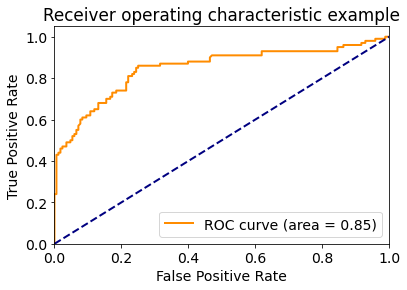

In [63]:
selected_Features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
X = train_data[selected_Features]
Y = train_data['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)
model = LogisticRegression(solver = 'liblinear', C = 0.10001,  random_state = 0) 
model.fit(X_train, y_train)
scores = cross_val_score(model, X, Y, cv = 10)
print("Cross-validated scores:", scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
predictions = cross_val_predict(model, X, Y, cv = 10)
confusion_matrix(Y, predictions)
print("model.intercept_", model.intercept_)
print("model.coef_", model.coef_)
predicted_y = model.predict(X_test)
predicted_y_prob = model.predict_proba(X_test)[:,1]
[fpr, tpr, thr] = roc_curve(y_test, predicted_y_prob)
roc_auc = auc(fpr, tpr)

lw = 2
plt.plot(fpr, tpr, color = 'darkorange',
         lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

In [70]:
test_data['Survived'] = model.predict(test_data[selected_Features])
test_data['PassengerId'] = test['PassengerId']

submission = test_data[['PassengerId','Survived']]

submission.to_csv("submission.csv", index=False)

submission.tail()

,PassengerId,Survived
413,1305,0
414,1306,1
415,1307,0
416,1308,0
417,1309,0
